# MovieLens with Collaboration Filtering from fastbook 08

In [1]:
from fastai.collab import *
from fastai.tabular.all import *

In [3]:
path = untar_data(URLs.ML_100k)

In [9]:
ratings = pd.read_csv(
    path/'u.data', delimiter='\t', header=None,
    names=['user', 'movie', 'rating', 'timestamp'])
ratings = ratings.drop(columns='timestamp')
ratings.head()

,user,movie,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [12]:
dls = CollabDataLoaders.from_df(ratings, item_name='movie', bs=64)
dls.show_batch()

,user,movie,rating
0,622,190,4
1,647,134,4
2,786,174,4
3,233,286,3
4,405,1540,2
5,301,404,3
6,495,665,1
7,222,1011,4
8,940,746,3
9,855,1021,3


In [13]:
L(dls.classes)

(#2) ['user','movie']

In [14]:
n_users = len(dls.classes['user'])
n_movies = len(dls.classes['movie'])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

## MSE for Dot products

In [17]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
    def forward(self, X):
        users = self.user_factors(X[:,0])
        movies = self.movie_factors(X[:,1])        
        return (users * movies).sum(dim=1)

epoch,train_loss,valid_loss,time
0,1.319163,1.301567,00:06
1,1.072238,1.126393,00:06
2,0.973071,1.006744,00:06
3,0.819768,0.915777,00:06
4,0.800278,0.895146,00:06


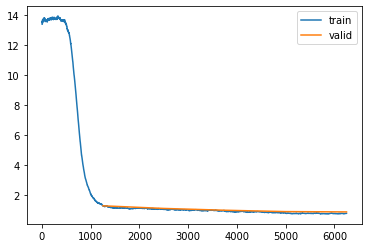

In [36]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

## Specify Rating range

In [31]:
class DotProductRange(DotProduct):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        super().__init__(n_users, n_movies, n_factors)
        self.y_range = y_range
    def forward(self, X):
        return sigmoid_range(super().forward(X), *self.y_range)

In [32]:
model = DotProductRange(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.003102,0.991639,00:06
1,0.872051,0.895169,00:06
2,0.663116,0.866403,00:06
3,0.477195,0.875070,00:06
4,0.354954,0.879459,00:06


## Add Bias respectively

In [33]:
class DotProductBias(DotProductRange):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        super().__init__(n_users, n_movies, n_factors, y_range=(0,5.5))
        self.user_bias = Embedding(n_users, 1)
        self.movie_bias = Embedding(n_movies, 1)
    def foward(self, x):
        y = super().forward(X)
        y += self.user_bias(X[:,0])
        y += self.movie_bias(X[:,1])
        return sigmoid_range(y, *self.y_range)

In [34]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.975578,0.985670,00:06
1,0.892065,0.903127,00:06
2,0.683729,0.865251,00:06
3,0.478993,0.868494,00:06
4,0.370724,0.872040,00:06


## With Decay (L2 regularization)

In [34]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.975578,0.985670,00:06
1,0.892065,0.903127,00:06
2,0.683729,0.865251,00:06
3,0.478993,0.868494,00:06
4,0.370724,0.872040,00:06


## Using fastai.collab

In [37]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.963955,0.955790,00:07
1,0.861782,0.877639,00:07
2,0.738184,0.837129,00:07
3,0.586984,0.824137,00:07
4,0.497118,0.824534,00:07


In [38]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1655, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1655, 1)
)

## Deep Learning for Collaborative Filtering

In [39]:
embs = get_emb_sz(dls)
embs

[(944, 74), (1655, 102)]

In [43]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0, 5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1),
        )
        self.y_range = y_range
    def forward(self, X):
        embs = self.user_factors(X[:,0]), self.item_factors(X[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

In [44]:
model = CollabNN(*embs)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.967367,0.956959,00:07
1,0.912710,0.909662,00:07
2,0.835822,0.888609,00:06
3,0.782297,0.876654,00:07
4,0.781319,0.875355,00:07


In [48]:
learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100])
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.981277,0.965048,00:07
1,0.905343,0.908017,00:07
2,0.843490,0.867771,00:08
3,0.821534,0.851313,00:07
4,0.756023,0.853258,00:07
